# # Homework: Week 1
Orhan Soyuhos

#### Bin sizes: 1ms, 5ms, 10ms, and 20ms

1ms - rasters and PSTH

5ms - rasters, PSTH, and receptive field analysis 

10ms, 20ms - PSTH

In [1]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
bin_size = 0.005 #select: 0.001, 0.005, 0.01, 0.02
idx = 'sig016b_event6' # select

## -> Dataset 

In [3]:
# Python: Reading JSON

#open file
f = open('hw1.json')
hw1_data = json.load(f)
f.close()

events_data = hw1_data['events']
neurons_data = hw1_data['neurons']

event_3_data = np.array(events_data['event_3'])
event_6_data = np.array(events_data['event_6'])
sig003a_data = np.array(neurons_data['sig003a'])
sig016b_data = np.array(neurons_data['sig016b'])

events_data.keys(), neurons_data.keys()

(dict_keys(['event_3', 'event_6']), dict_keys(['sig003a', 'sig016b']))

In [4]:
len(event_3_data), len(event_6_data), len(sig003a_data), len(sig016b_data)

(77, 80, 30316, 66168)

### -> Calculate the relative_spikes

In [5]:
relative_spikes = dict()

tmp_data = list()
for event_time in event_3_data:
    tmp_data.append(list(sig003a_data - event_time))
relative_spikes['sig003a_event3'] = tmp_data

tmp_data = list()
for event_time in event_6_data:
    tmp_data.append(list(sig003a_data - event_time))
relative_spikes['sig003a_event6'] = tmp_data

tmp_data = list()
for event_time in event_3_data:
    tmp_data.append(list(sig016b_data - event_time))
relative_spikes['sig016b_event3'] = tmp_data

tmp_data = list()
for event_time in event_6_data:
    tmp_data.append(list(sig016b_data - event_time))
relative_spikes['sig016b_event6'] = tmp_data

relative_spikes.keys()

dict_keys(['sig003a_event3', 'sig003a_event6', 'sig016b_event3', 'sig016b_event6'])

### -> Calculate the relative response matrix (rrm)

In [6]:
def compute_rrm(relative_spikes, bin_size):

    # Calculate the relative response matrix 
    rrm = []
    for relative_spike in relative_spikes:
        baseline_start = -0.2
        baseline_end = 0
        response_start = 0
        response_end = 0.2
        event_window = list(np.arange(baseline_start, response_end, bin_size))
        total_bins = len(event_window)
        # relative_spikes is the offset spike times for a given trial
        # np.histogram returns an array [histogram, bin_edges] so the call below only grabs the histogram
        binned_spikes = np.histogram(relative_spike, total_bins, range = (baseline_start, response_end))[0]
        rrm.append(binned_spikes)

    return rrm

In [7]:
rrm = dict() 

# sig003a_event1
relative_spi = relative_spikes['sig003a_event3']
rrm['sig003a_event3'] = compute_rrm(relative_spi, bin_size)

# sig003a_event4
relative_spi = relative_spikes['sig003a_event6']
rrm['sig003a_event6'] = compute_rrm(relative_spi, bin_size)

# sig016b_event1
relative_spi = relative_spikes['sig016b_event3']
rrm['sig016b_event3'] = compute_rrm(relative_spi, bin_size)

# sig016b_event4
relative_spi = relative_spikes['sig016b_event6']
rrm['sig016b_event6'] = compute_rrm(relative_spi, bin_size)

rrm.keys()

dict_keys(['sig003a_event3', 'sig003a_event6', 'sig016b_event3', 'sig016b_event6'])

## # Receptive Field Analysis + Write JSON

In [8]:
def receptive_field_analysis(rrm):

    results = dict()
    
    for idx in rrm.keys():

        rrm_selected = rrm[idx]
        psth = np.mean(rrm_selected, 0)

        baseline_start = -0.2
        response_end = 0.2
        start_bin = len(rrm_selected[0]) // 2

        # Calculate background firing rate, threshold, latencies, peak and response magnitude etc.
        bfr = np.mean(psth[:start_bin]) 
        threshold = bfr + np.std(psth[:start_bin], ddof=1) * 3

        fb = -1
        lb = 0
        peak = 0
        for i in range(len(psth)):
            if fb <= 0 and psth[i] > threshold:
                fb = i
            if psth[i] > threshold:
                lb = i
            if peak < psth[i]:
                peak = psth[i]
                peak_b = i

        rm = np.sum(psth[fb:lb+1])

        fbl = ((fb - start_bin) * bin_size) + bin_size/2
        lbl = ((lb - start_bin) * bin_size) + bin_size/2
        peak_latency = ((peak_b - start_bin) * bin_size) + bin_size/2
            
        neuron, event = idx.split('_') 
        if event not in results:
            results[event] = dict()
        if neuron not in results[event]:
            results[event][neuron] = dict()
        
        results[event][neuron]['background_rate'] = bfr.tolist()
        results[event][neuron]['first_bin'] = fb
        results[event][neuron]['first_bin_latency'] = fbl
        results[event][neuron]['last_bin'] = lb
        results[event][neuron]['last_bin_latency'] = lbl
        results[event][neuron]['peak_firing_rate'] = peak.tolist()
        results[event][neuron]['peak_latency'] = peak_latency
        results[event][neuron]['response_magnitude'] = rm.tolist()
        results[event][neuron]['threshold'] = threshold.tolist()
        results[event][neuron]['psth'] = psth.tolist()
                
    return results

In [9]:
rfa_results = receptive_field_analysis(rrm)

with open(f'Soyuhos_Orhan_hw1_{bin_size}.json', 'w') as f_out:
    json.dump(rfa_results, f_out, indent=4, sort_keys=True)

## # Raster Plots
Create a raster plot that has trial number on the y-axis and time on the x-axis where the spike times of the neuron are plotted relative to the stimulus time (set time zero to the stimulus time). The trial number comes from the identity of the stimulation times (trial 1 is the time of the first stimulus). For each neuron, for each stimulus (4 plots total), plot the spike times for every trial. Use a 1 millisecond resolution for the x axis and plot from 200ms before the stimulus to 200ms after the stimulus.

In [10]:
rrm_selected = rrm[idx]
np.shape(rrm_selected), type(rrm_selected)

((80, 80), list)

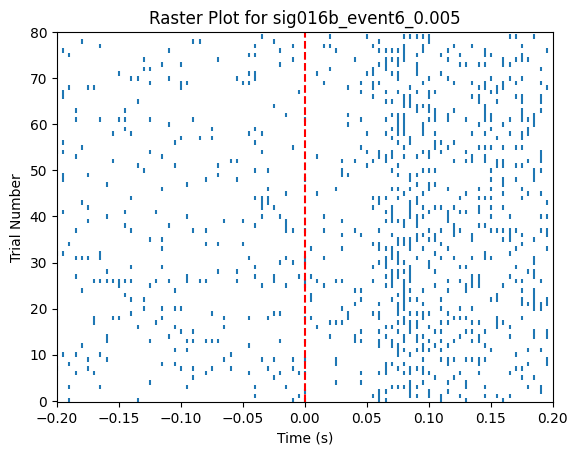

In [11]:
baseline_start = -0.2
response_end = 0.2
raster_data = np.random.random([len(rrm_selected), len(rrm_selected[0])])
for k in range(len(rrm_selected)):
    for l in range(len(rrm_selected[k])):
        if rrm_selected[k][l] == 0:
            raster_data[k][l] = math.nan
        else:
            raster_data[k][l] = l * bin_size + baseline_start

plt.eventplot(raster_data)
plt.ylim([baseline_start, len(rrm_selected)])
plt.xlim([baseline_start, response_end])
plt.ylabel('Trial Number')
plt.xlabel('Time (s)')
plt.title(f'Raster Plot for {idx}_{bin_size}')
plt.axvline(x = 0, color = 'red', linestyle = '--')

plt.savefig(f'raster_{idx}_{str(bin_size)}.png')

## # PSTH

Create a normalized histogram (Normalize by total event trials) for each neuron for each event with 1ms, 5ms, 10ms, and 20ms bin sizes. Compare the histograms to each other and state which bin size you think best captures the neuron activity and why. Turn in the histogram for each bin size, for each neuron for each event.

/var/folders/1j/r5d3f6351yd2fkfgn9dl6mwh0000gq/T/ipykernel_22592/1063717666.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + xticklabels_str + [''])


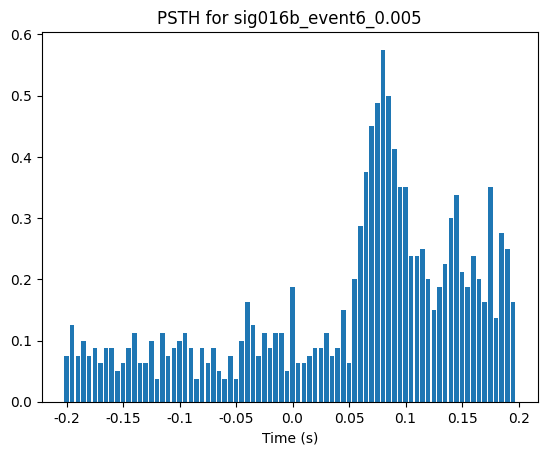

In [12]:
baseline_start = -0.2
response_end = 0.2

# Calculate the PSTH     
psth = np.mean(rrm_selected, 0)

fig, ax = plt.subplots()

ax.bar(range(len(rrm_selected[0])), psth)
ax.set_xlabel('Time (s)')
ax.set_title(f'PSTH for {idx}_{bin_size}')

xticklabels = np.linspace(baseline_start, response_end, len(ax.get_xticklabels())-2)
xticklabels_str = []
for xticklabel in xticklabels:
    xticklabels_str.append(str(round(xticklabel,2)))
xticklabels_str
ax.set_xticklabels([''] + xticklabels_str + [''])

plt.show()
fig.savefig(f'psth_{idx}_{str(bin_size)}.png')